<a href="https://colab.research.google.com/github/kartik727/ml-projects/blob/master/adversarial-examples/Adversarial_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import random
import os
import logging

## Setting up

In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
#@title Loading model
#@markdown Load the pre-trained model or train fresh
dir = '/content/ml-projects/adversarial-examples/model_wts'
load_pre_trained_model = True #@param {type:"boolean"}
pre_trained_loc = dir+'/cp.ckpt'
train_model = False #@param {type:"boolean"}
num_epochs = 50 #@param {type:"integer"}
callbacks = None

In [4]:
if load_pre_trained_model:
    logging.info('Downloading the repo with weights for the pre-trained model')
    ! git clone https://github.com/kartik727/ml-projects.git

INFO:root:Downloading the repo with weights for the pre-trained model


Cloning into 'ml-projects'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15 (delta 2), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (15/15), done.


## Data

Dataset used: CIFAR-10

In [5]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
logging.info('CIFAR-10 dataset loaded')

170508288/170498071 [==============================] - 2s 0us/step


INFO:root:CIFAR-10 dataset loaded


In [6]:
# Normalizing uint8 values to floats between 0 and 1
X_train = X_train / 255
X_test = X_test / 255

logging.info(f'Train set size: {len(X_train)}')
logging.info(f'Test set size: {len(X_test)}')

INFO:root:Train set size: 50000
INFO:root:Test set size: 10000


In [7]:
# Converting numpy arrays into tf datasets

ds_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
ds_train = ds_train.cache().shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

ds_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
ds_test = ds_test.cache().shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
text_labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

## Trainig NN

Try training models with different architectures and see if creating adversarial examples gets easier/harder.

In [9]:
model = Sequential([
    layers.InputLayer(input_shape=(32, 32, 3)),
    layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        2336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 8, 8, 32)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          1

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
if load_pre_trained_model:
    model.load_weights(pre_trained_loc)
    model.evaluate(ds_test)

313/313 [==============================] - 10s 4ms/step - loss: 0.7033 - accuracy: 0.7620


In [12]:
if train_model:
    model_history = model.fit(ds_train,
                            validation_data=ds_test,
                            epochs=num_epochs,
                            callbacks=callbacks)
else:
    logging.info('Not training the model')

INFO:root:Not training the model


## Results

In [13]:
def get_preds_probs(X, model):
    '''
    Get the prediction and assigned probability by the model for a given image 
    '''
    Y_logits = model(X)
    Y_probs = tf.nn.softmax(Y_logits, axis=1)
    Y_preds = tf.math.argmax(Y_probs, axis=1)
    Y_probs = tf.math.reduce_max(Y_probs, axis=1)
    return Y_preds, Y_probs

In [14]:
# Getting the predictions (label with highest probability) to create the
# confusion matrix

Y_test_preds, _ = get_preds_probs(X_test, model)
conf_matrix = confusion_matrix(Y_test.squeeze(), Y_test_preds)

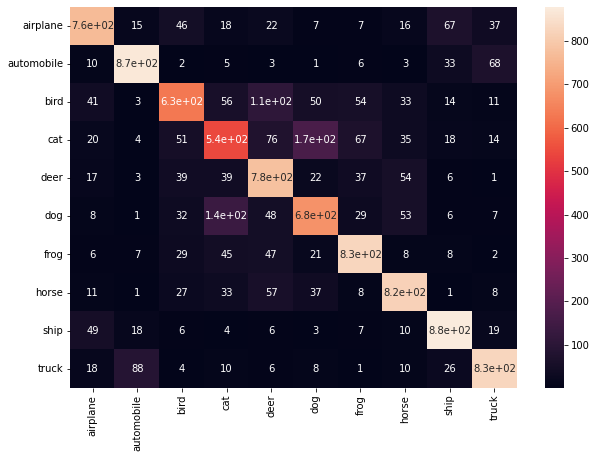

In [15]:
# Creating a heatmap from the confusion matrix

df_cm = pd.DataFrame(conf_matrix, index = text_labels, columns = text_labels)
fig = plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
fig.show()

In [16]:
def show_images(rows, cols, images, preds, probs, labels):
    '''
    Creates a matric of sample images with their true and predicted labels
    '''
    fig = plt.figure(figsize=(16, 12))
    for row in range(rows):
        for col in range(cols):
            idx = col + row*cols
            label, pred, prob = labels[idx], preds[idx], probs[idx]
            txt_label, txt_pred = text_labels[label], text_labels[pred]
            fig.add_subplot(rows, cols, idx+1)
            plt.imshow(images[idx])
            plt.axis('off')
            plt.title(f'True Label: {label} ({txt_label})\nPrediction: {pred} ({txt_pred}) [{prob*100:.2f}%]')

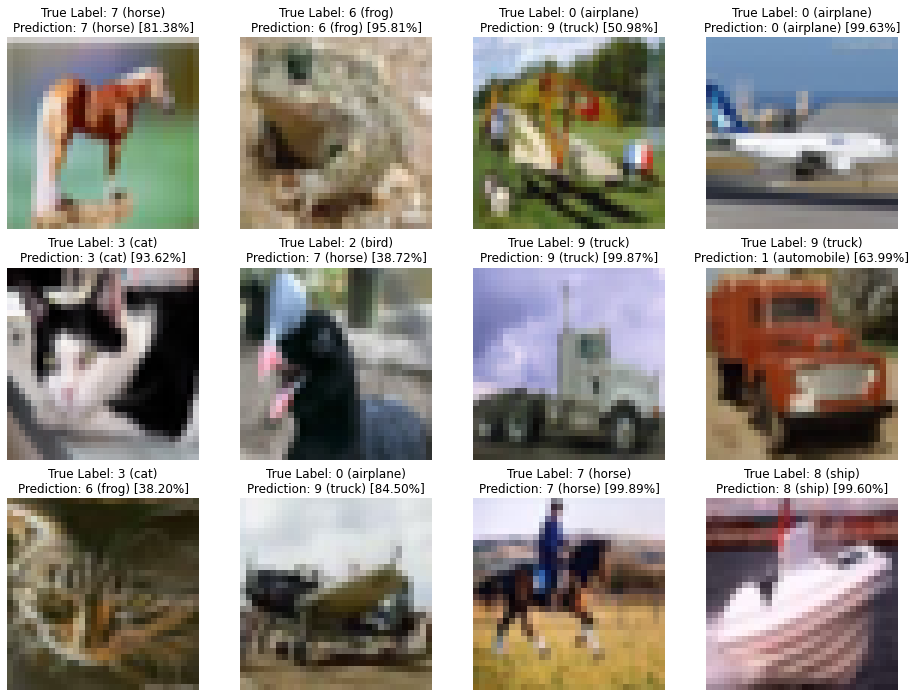

In [17]:
# Taking a batch of images for visualizing the dataset and the performance
# of the model.

for batch in ds_test.take(1):
    X, Y = batch
    preds, probs = get_preds_probs(X, model)
    show_images(3, 4, X, preds, probs, Y.numpy().squeeze())

## Creating adversarial examples

Based on: https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    '''
    Gets the signs of the gradients for the input image
    '''
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

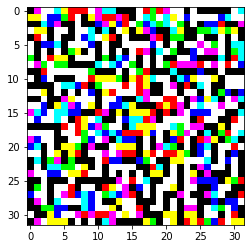

In [27]:
# Try with train and test sets
X, Y = X_train, Y_train
# X, Y = X_test, Y_test

num_samples = 3

# Get the input label of the image.
sample_idxs = random.choices(range(len(X)), k=num_samples)
labels = Y.squeeze()[sample_idxs]
sample_images = X[sample_idxs]
tensor = tf.convert_to_tensor(sample_images)

perturbations = create_adversarial_pattern(tensor, labels)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

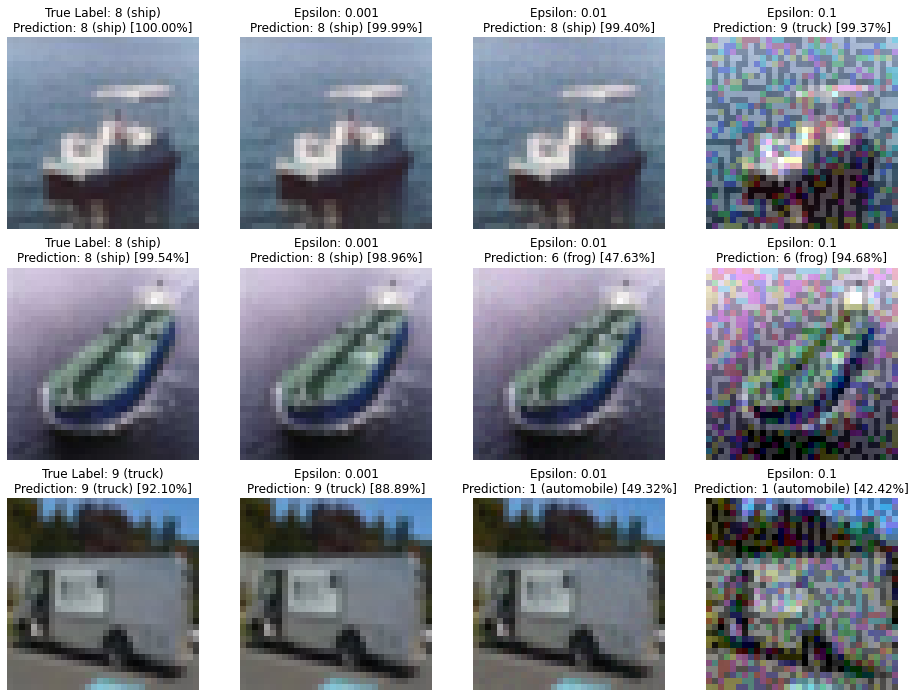

In [28]:
# Applying the gradient signs in different amounts and observing the change in predictions

epsilons = [0, 1e-3, 1e-2, 0.1]
rows, cols = num_samples, len(epsilons)

fig = plt.figure(figsize=(16, 12))
for row in range(rows):
    images = np.array([sample_images[row] + ep*perturbations[row] for ep in epsilons])
    preds, probs = get_preds_probs(images, model)
    label = labels[row]
    txt_label = text_labels[label]
    for col in range(cols):
        idx = col + row*cols
        pred, prob = preds[col], probs[col]
        txt_pred = text_labels[pred]
        if col==0:
            title = f'True Label: {label} ({txt_label})\nPrediction: {pred} ({txt_pred}) [{prob*100:.2f}%]'
        else:
            title = f'Epsilon: {epsilons[col]}\nPrediction: {pred} ({txt_pred}) [{prob*100:.2f}%]'
        fig.add_subplot(rows, cols, idx+1)
        plt.imshow(images[col])
        plt.axis('off')
        plt.title(title)